<a href="https://colab.research.google.com/github/sandeeppalakkal/ML_Datascience_Practice/blob/master/CIFAR10_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Get CIFAR10 data
def get_cifar10(transform=None):
  trainset = torchvision.datasets.CIFAR10(root='./root',train=True,download=True,transform=transform)
  valset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return trainset, valset, classes

In [3]:
def dataloader(batch_size):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(3*[0.5], 3*[0.5])])
  trainset,valset, classes = get_cifar10(transform)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, num_workers=2)
  return train_loader, val_loader, classes

# Training Module

In [39]:
def train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device):

  # start training
  losses = []
  acc = []
  val_losses = []
  val_acc = []
  for epoch in range(n_epochs):
    running_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        images,labels = data[0].to(device),data[1].to(device)

        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = torch.argmax(outputs.data, 1)
        correct += (predictions == labels).float().sum().item()
        total += labels.size(0)
    
    losses.append(running_loss / len(train_loader))
    acc.append(correct / total * 100)

    # Test model
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
      correct = 0
      running_loss = 0
      total = 0
      for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        running_loss += criterion(outputs, labels).item()
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      val_acc.append(100 * correct / total)
      val_losses.append(running_loss/len(val_loader))

    print(f'[Epoch: {epoch + 1}] \
    train loss: {losses[-1]:.3f}; val loss: {val_losses[-1]:.3f}; \
    train accuracy: {acc[-1]:.2f}%; test accuracy: {val_acc[-1]:.2f}%') 

  print('Finished Training')
  return net, losses, acc, val_losses, val_acc

# Define Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [46]:
class Net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Train Model

In [28]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
lr = 0.001
momentum = 0.9
batch_size = 32
n_epochs = 50

In [32]:
# Data loader
train_loader,val_loader,classes = dataloader(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
# define network for training
net = Net1().to(device)

In [41]:
# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

In [42]:
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

[Epoch: 1]     train loss: 2.287; val loss: 2.194     train accuracy: 13.62%; test accuracy: 19.19%
[Epoch: 2]     train loss: 1.926; val loss: 1.712     train accuracy: 28.91%; test accuracy: 36.41%
[Epoch: 3]     train loss: 1.631; val loss: 1.538     train accuracy: 39.79%; test accuracy: 43.45%
[Epoch: 4]     train loss: 1.507; val loss: 1.439     train accuracy: 45.03%; test accuracy: 47.25%
[Epoch: 5]     train loss: 1.408; val loss: 1.357     train accuracy: 48.66%; test accuracy: 51.12%
[Epoch: 6]     train loss: 1.336; val loss: 1.331     train accuracy: 51.73%; test accuracy: 52.24%
[Epoch: 7]     train loss: 1.271; val loss: 1.265     train accuracy: 54.39%; test accuracy: 54.60%
[Epoch: 8]     train loss: 1.212; val loss: 1.206     train accuracy: 56.61%; test accuracy: 56.93%
[Epoch: 9]     train loss: 1.164; val loss: 1.210     train accuracy: 58.55%; test accuracy: 57.18%
[Epoch: 10]     train loss: 1.119; val loss: 1.140     train accuracy: 60.36%; test accuracy: 60.12%

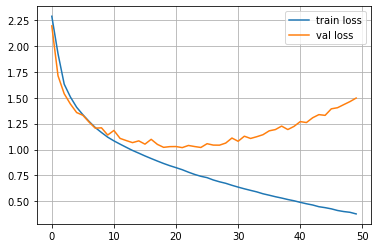

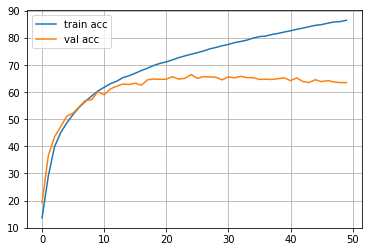

In [44]:
# Plot loss
import matplotlib.pyplot as plt
def plot_losses(train_losses, val_losses, train_acc, val_acc):
  plt.plot(train_losses,label='train loss')
  plt.plot(val_losses,label='val loss')
  plt.legend()
  plt.grid()
  plt.show()
  plt.plot(train_acc, label='train acc')
  plt.plot(val_acc, label='val acc')
  plt.legend()
  plt.grid()
  plt.show()

plot_losses(losses, val_losses, acc, val_acc)

**Conclusion:** model is over-fitting to training set

# 2nd Training: Dropout

Files already downloaded and verified
Files already downloaded and verified
[Epoch: 1]     train loss: 2.239; val loss: 2.011     train accuracy: 16.43%; test accuracy: 26.15%
[Epoch: 2]     train loss: 1.876; val loss: 1.746     train accuracy: 30.32%; test accuracy: 34.92%
[Epoch: 3]     train loss: 1.673; val loss: 1.603     train accuracy: 38.23%; test accuracy: 41.56%
[Epoch: 4]     train loss: 1.572; val loss: 1.547     train accuracy: 42.62%; test accuracy: 44.17%
[Epoch: 5]     train loss: 1.499; val loss: 1.488     train accuracy: 45.41%; test accuracy: 46.08%
[Epoch: 6]     train loss: 1.441; val loss: 1.418     train accuracy: 47.46%; test accuracy: 48.21%
[Epoch: 7]     train loss: 1.393; val loss: 1.396     train accuracy: 49.36%; test accuracy: 49.51%
[Epoch: 8]     train loss: 1.349; val loss: 1.375     train accuracy: 51.08%; test accuracy: 50.56%
[Epoch: 9]     train loss: 1.312; val loss: 1.323     train accuracy: 52.70%; test accuracy: 52.62%
[Epoch: 10]     train lo

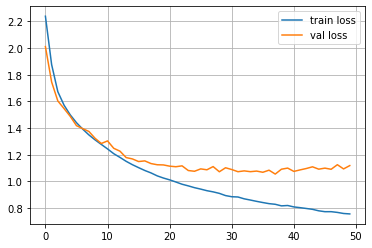

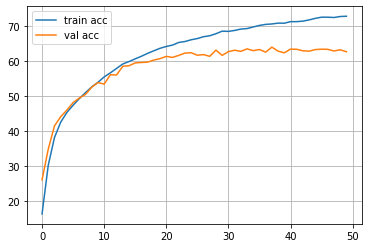

In [47]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001
momentum = 0.9
batch_size = 32
n_epochs = 50

# Data loader
train_loader,val_loader,classes = dataloader(batch_size)

# define network for training
net = Net2().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# train
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)